## warehouse collision 해결하고 warehouse에 코드로 넣기

In [3]:
import os
import numpy as np
from crewai import Agent, Task, Crew
from environment import Environment
from openai import OpenAI
import configs
import pickle

os.environ["OPENAI_API_KEY"] = ""
client = OpenAI()

In [4]:
#negotiator를 구성하기 위한 union find 알고리즘

def find(parent, i):
    if parent[i] == i:
        return i
    else:
        return find(parent, parent[i])

def union(parent, rank, x, y):
    xroot = find(parent, x)
    yroot = find(parent, y)

    if xroot != yroot:
        if rank[xroot] < rank[yroot]:
            parent[xroot] = yroot
        elif rank[xroot] > rank[yroot]:
            parent[yroot] = xroot
        else:
            parent[yroot] = xroot
            rank[xroot] += 1

def merge_sets(lists):
    element_to_index = {}
    for i, subset in enumerate(lists):
        for element in subset:
            element_to_index[element] = i

    parent = [i for i in range(len(lists))]
    rank = [0] * len(lists)

    for subset in lists:
        first_element = subset[0]
        for element in subset[1:]:
            union(parent, rank, find(parent, element_to_index[first_element]), find(parent, element_to_index[element]))

    new_sets = {}
    for element in element_to_index:
        root = find(parent, element_to_index[element])
        if root not in new_sets:
            new_sets[root] = set()
        new_sets[root].add(element)

    return [list(s) for s in new_sets.values()]

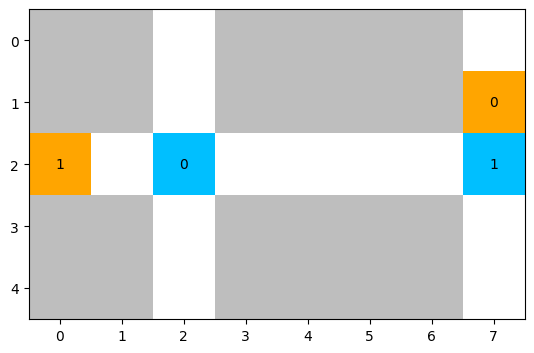

In [5]:
directiondict = {
    'Stay': 0, 'North': 1, 'South': 2, 'West': 3, 'East': 4, 'Stay.': 0, 'North.': 1, 'South.': 2, 'West.': 3, 'East.': 4 
}

# Toy example 만들기(환경, 처음 위치, 목적지)
toy = (np.array([[1, 1, 0, 1, 1, 1, 1, 0], [1, 1, 0, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 1, 1, 1, 1, 0], [1, 1, 0, 1, 1, 1, 1, 0]]), np.array([[2, 2], [2, 7]]), np.array([[1, 7], [2, 0]]))
num_agents = len(toy[1])
map_width = len(toy[0][0]) - 1

env = Environment()
env.load(toy[0], toy[1], toy[2])
env.render()

In [6]:
class PathFindingAgents:
  def path_finder(self, agent_number):
    return Agent(
      role='Path finder',
      goal='Start at the start point and reach the end point without crashing into a wall.',
      backstory=f"""You are a veteran adventurer with a great sense of direction.
      You understand which direction you need to move to get from where you are to where you want to go.
      Your agent number is {agent_number}.
      """,
      verbose=True
    )
    
  def negotiator(self):
    return Agent(
      role='Negotiator',
      goal="""Determine whether the deadlocked agents would collide with each other if they took their original planned moves, and if so, stop all but the agent with the largest number.""",
      backstory="""You're a veteran overseer, and you've been called in to resolve the deadlock, as each agent is in the other's line of sight.
      """,
      verbose=True,
    )
	
class PathFindingTasks():
  def path_finding(self, agent, x, y, x_finish, y_finish, east, west, north, south, last_action):
    return Task(
      description=(
        f"""
        Your current coordinates are ({x},{y}) and your destination is ({x_finish},{y_finish}).
        East and west in the coordinates correspond to the x axis.
        South and north in the coordinates correspond to the y axis.
        You can only move east, west, south and north or stay.
        So, your answer will be {{East}}, {{West}}, {{South}}, {{North}}, or {{Stay}}.
        You can only make one move at a time.
        {east}
        {west}
        {south}
        {north}
        Which direction do you move next?
        {last_action}
        Answer in one word only: {{DIRECTION or ACTION}}
        """
      ),
      expected_output='Direction or action',
      agent=agent
    )
    
  def negotiate(self, agent):
    return Task(
      description=(
        f"""
        Determine whether the deadlocked agents would collide with each other if they took their original planned moves, and if so, stop all but the agent with the largest number.
        The planned moves of each agent represent the previous outcomes.
        """
      ),
      expected_output='Direction of the agents',
      agent=agent
    )

agents = PathFindingAgents()
tasks = PathFindingTasks()

agents_set = [agents.path_finder(i) for i in range(num_agents)]
negotiator = agents.negotiator()

In [7]:
#에이전트들의 지난번 액션들
action_list = [[] for _ in range(num_agents)]



> Entering new CrewAgentExecutor chain...


2024-06-12 12:16:32,137 - 23420 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current location and the destination, I need to move in the direction that gets me closer to the destination. As the destination is located more to the east and slightly to the north from my current position, I should move eastwards.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering my current location and the destination, the most feasible direction to move would be west as it will bring me closer to the end point on the x-axis.

Final Answer: West

> Finished chain.


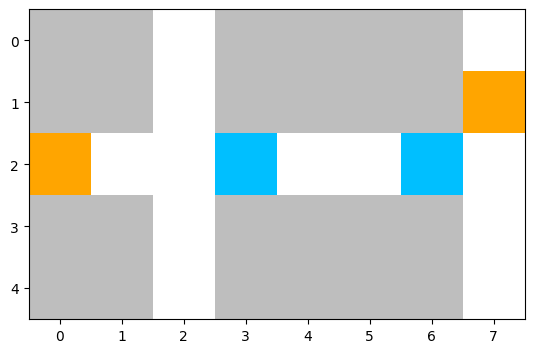

In [8]:
# 1 turn
for n in range(1):

  step = [0 for i in range(num_agents)]

  #각 에이전트들의 시야에 있는 자신과 다른 에이전트들
  FOV_agents = []
  for i in range(num_agents):
    if np.any(env.observe()[0][i][0][2:7, 2:7]):
      non_zero_elements = env.observe()[0][i][0][2:7, 2:7][env.observe()[0][i][0][2:7, 2:7] != 0].tolist()
      non_zero_elements = [element - 1 for element in non_zero_elements]
      non_zero_elements.append(i)
      FOV_agents.append(non_zero_elements)

  #알고리즘을 이용해 연결된 집합 찾기
  connected_set = merge_sets(FOV_agents)

  #연결이 있는 모든 에이전트들
  deadlocked_agents = [item for sublist in connected_set for item in sublist]

  for i in range(num_agents):

    #교착상태에 빠지지 않은 에이전트는 독립적으로 navigate
    if i not in deadlocked_agents:
      
      a_obs = env.observe()[0][i][1]
      x = env.observe()[1][i][1]
      y = map_width-env.observe()[1][i][0]
      x_finish = toy[2][i][1]
      y_finish = map_width-toy[2][i][0]

      if a_obs[4][3] == 0:
        west = """To your west lies a path."""
      else:
        west = """Your west is blocked by a wall."""

      if a_obs[4][5] == 0:
        east = """To your east lies a path."""
      else:
        east = """Your east is blocked by a wall."""

      if a_obs[5][4] == 0:
        south = """To your south lies a path."""
      else:
        south = """Your south is blocked by a wall."""

      if a_obs[3][4] == 0:
        north = """To your north lies a path."""
      else:
        north = """Your north is blocked by a wall."""

      if len(action_list[i]) == 0:
        last_action = """"""
      elif action_list[i][-1] in ['West', 'West.']:
        last_action = f"""You came from east."""
      elif action_list[i][-1] in ['East', 'East.']:
        last_action = f"""You came from west."""
      elif action_list[i][-1] in ['South', 'South.']:
        last_action = f"""You came from north."""
      elif action_list[i][-1] in ['North', 'North.']:
        last_action = f"""You came from south."""
      elif action_list[i][-1] in ['Stay', 'Stay.']:
        last_action = f"""You paused once for another agent or you reached your goal."""
      else:
        last_action = """"""

      navigation = tasks.path_finding(agents_set[i], x, y, x_finish, y_finish, east, west, north, south, last_action)

      crew = Crew(
        agents=[agents_set[i]],
        tasks=[navigation],
        verbose=0,
      )

      result = crew.kickoff()

      action_list[i].append(result)
    
      step[i] = directiondict[result]

  
  #여기에 교착상태에 빠진 에이전트들을 계획.




  env.step(step)
  env.render()

### 교착상태 실험(잘 되면 위 코드로 넣기)

In [76]:
FOV_agents = []
for i in range(num_agents):
  if np.any(env.observe()[0][i][0][2:7, 2:7]):
    non_zero_elements = env.observe()[0][i][0][2:7, 2:7][env.observe()[0][i][0][2:7, 2:7] != 0].tolist()
    non_zero_elements = [element - 1 for element in non_zero_elements]
    non_zero_elements.append(i)
    FOV_agents.append(non_zero_elements)

connected_set = merge_sets(FOV_agents)
deadlocked_agents = [item for sublist in connected_set for item in sublist]

In [77]:
texts = []
results = []

for i in connected_set[0]: # 여기서 i는 agent의 고유번호
    
    a_obs = env.observe()[0][i][1]
    x = env.observe()[1][i][1]
    y = map_width-env.observe()[1][i][0]
    x_finish = toy[2][i][1]
    y_finish = map_width-toy[2][i][0]

    if a_obs[4][3] == 0:
        west = """To your west lies a path."""
    else:
        west = """Your west is blocked by a wall."""

    if a_obs[4][5] == 0:
        east = """To your east lies a path."""
    else:
        east = """Your east is blocked by a wall."""

    if a_obs[5][4] == 0:
        south = """To your south lies a path."""
    else:
        south = """Your south is blocked by a wall."""

    if a_obs[3][4] == 0:
        north = """To your north lies a path."""
    else:
        north = """Your north is blocked by a wall."""

    if len(action_list[i]) == 0:
        last_action = """"""
    elif action_list[i][-1] in ['West', 'West.']:
        last_action = f"""You came from east."""
    elif action_list[i][-1] in ['East', 'East.']:
        last_action = f"""You came from west."""
    elif action_list[i][-1] in ['South', 'South.']:
        last_action = f"""You came from north."""
    elif action_list[i][-1] in ['North', 'North.']:
        last_action = f"""You came from south."""
    elif action_list[i][-1] in ['Stay', 'Stay.']:
        last_action = f"""You paused once for another agent or you reached your goal."""
    else:
        last_action = """"""

    navigation = tasks.path_finding(agents_set[i], x, y, x_finish, y_finish, east, west, north, south, last_action)

    crew = Crew(
        agents=[agents_set[i]],
        tasks=[navigation],
        verbose=0,
    )

    result = crew.kickoff()

    results.append(result)

    if result.lower().strip('.') == 'stay':
        texts.append(f"""Agent {i} plans to stay at coordinate ({x}, {y}).""")
    else:
        texts.append(f"""Agent {i} plans to move {result.lower().strip('.')} from coordinate ({x}, {y}).""")

response = client.chat.completions.create(
  model="gpt-4",
  messages=[
    {"role": "system", "content": "You are the overseer of the pathfinders' movements. You have a great sense of direction."},
    {"role": "user", "content": f"""
     {' '.join(texts)}
     Agents will collide if they swap locations or if their locations overlap.
     Will they collide?
     Your answer will be {{Yes}} or {{No}}.
     """},
  ]
)

if response.choices[0].message.content == 'No':
    for idx, pos in enumerate(connected_set[0]):
        step[pos] = directiondict[results[idx]]
else:
    

2024-06-12 11:52:56,250 - 18848 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-12 11:52:59,905 - 18848 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current coordinates (4,5) and my destination (7,6), I need to move towards the east to increase my x-coordinate. Since I came from the west and the paths to the east and west are clear, while the north and south are blocked, my best option would be to proceed towards the east.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...
Based on my current coordinates, my destination is west of my current position. Since I can't move north or south because of the walls and moving east would take me further away from my destination, my best option is to move west.

Final Answer: West

> Finished chain.


In [82]:
connected_set[0]

[0, 1]

In [81]:
results

['East', 'West']

In [87]:
for idx, pos in enumerate(connected_set[0]):
        step[pos] = directiondict[results[idx]]